# Nasa Space apps challenge 2023

### Magnetic Reconnection - PhyData Team 

Magnetic reconnection (MR) is a process in which opposing magnetic field lines merge. If magnetic reconnection occurs between the interplanetary magnetic field (IMF) and Earth’s magnetic field, solar-wind plasma particles are permitted to enter the region of space near Earth (the geospace), potentially causing space weather events that could impact satellites in Earth orbit, as well as power systems on Earth. Your challenge is to develop a computer program for the public that analyzes the IMF vector components measured by spacecraft to assess how often magnetic reconnection occurs.

NASA’s Advanced Composition Explorer (ACE) and Wind missions and NOAA’s Deep Space Climate Observatory (DSCOVR) mission are located at Lagrange point 1 (L1) (a location about one million miles towards the Sun from Earth) and routinely measure the IMF. 

<img src="1024px-Lagrange_points2.svg.png" width="50%" align="" />

The IMF is a vector that can be characterized by three independent components (X, Y, Z). In the Geocentric Solar Magnetospheric (GSM) Coordinate System, the X-axis points from Earth to the Sun. The Y-axis is defined to be perpendicular to the Earth's magnetic dipole so that the X-Z plane contains the Earth's dipole axis. The positive Z-axis is in the direction of Earth's northern magnetic pole. A crucial condition for magnetic reconnection is simultaneous occurrence of opposite polarities of the Z components of the IMF and the Z component of Earth’s magnetic field.

We present a code where we perform statistical analysis of the vector components of the IMF. 

### Code

We import the required libraries

In [ ]:
# install libraries
!pip install lifelines


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# import libraries
import numpy as np
import numpy.linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

pd.options.mode.chained_assignment = None  # default='warn'

We obtained the data from https://cdaweb.gsfc.nasa.gov/cgi-bin/eval1.cgi. Corresponding to the hourly IMF and Plasma Data, and Energetic Proton Fluxes, Time-Shifted to the Nose of the Earth's Bow Shock, plus Solar and Magnetic Indices - J.H. King, N. Papitashvili (ADNET, NASA GSFC). 

In [ ]:
# leer data OMNIWeb 
df = pd.read_csv('OMNI2_H0_MRG1HR_108679.csv', skiprows=139)
#  Solo data de WIND --> 51 y ACE --> 71
df_WA = df[(df['1AU_IMF_S/C_ID#_'] == 51) | (df['1AU_IMF_S/C_ID#_'] == 71)]

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We rename the columns to analize the physical properties of the data.  

In [ ]:
# Renombrar columnas de interes
df_WA = df_WA[['TIME_AT_CENTER_OF_HOUR_yyyy-mm-ddThh:mm:ss.sssZ', # time
                '1AU_IMF_S/C_ID#_', 
                '1AU_IP_BX__GSE_nT',
                '1AU_IP_BY__GSM_nT',
                '1AU_IP_BZ__GSM_nT',
                'NO._IMF_PTS_',
                'NO._IP_PLASMA_PTS_', 
                '1AU_IP_PLASMA_TEMP_Deg_K',
                '1AU_IP_N_(ION)_Per_cc',
                '1AU_IP_PLASMA_SPEED_Km/s',
                '1AU_IP_FLOW_LONG_Deg',
                '1AU_IP_FLOW_LAT_Deg',
                '1AU_IP_ALPHA/PROTON_',
                '1AU_IP_FLOW_PRESSURE_nPa',
                '1AU_IP_MAG_AVG_B-VECTOR_nT']] 

col_names = df_WA.columns.to_list()
column_names = {col_names[0]: 'Time',
                col_names[1]: 'Mission_ID',
                col_names[2]: 'Bx',
                col_names[3]: 'By',
                col_names[4]: 'Bz',
                col_names[5]: 'IMF',
                col_names[6]: 'Plasma',
                col_names[7]: 'Temp_K',
                col_names[8]: 'N_in_per_cc',
                col_names[9]: 'Plasma_Speed',
                col_names[10]: 'Flow_Long_Deg',
                col_names[11]: 'Floe_Lat_Deg',
                col_names[12]: 'Alpha/Proton',
                col_names[13]: 'Flow_Pressure',
                col_names[14]: 'Avg_B',
                }

df_WA.rename(columns=column_names, inplace=True)  

We start by doing the exploratory data analysis of the data

In [ ]:
# Consideramos solo data entre el 2010-2016
df_WA['Timestamp'] = pd.to_datetime(df_WA['Time'])
df_WA["Date"] = pd.to_datetime(df_WA['Timestamp'], unit="ms")
df_WA['Hour'] =  df_WA['Date'].dt.hour
df_WA = df_WA[(df_WA['Date'] >= '2010-01-01') & (df_WA['Date'] <= '2016-12-31')]
# Le damos formatos al tiempo
df_WA['Date'] = pd.to_datetime(df_WA['Date']).dt.tz_localize(None)
df_WA['Date'] = df_WA['Date'].dt.floor('h')


In [ ]:
# Etiquetamos las los valores negativos de Bz
df_WA['neg_Bz'] =  df_WA.apply(lambda x: 1 if x['Bz'] < 0 else 0, axis=1) 
# Dividimos los neg_Bz en cuartiles
df_WA = df_WA[df_WA['neg_Bz'] == 1]
df_WA['QuantileRank'] = pd.qcut(df_WA['Bz'], q = 10, labels = False)
dummies_df_WA = pd.get_dummies(df_WA["QuantileRank"] , prefix = 'Q', dtype=int)
dummies_df_WA = dummies_df_WA[["Q_0", "Q_1","Q_2", "Q_3","Q_4", "Q_5","Q_6", "Q_7","Q_8", "Q_9"]]
df_WA = pd.concat([df_WA, dummies_df_WA],  axis = 1)


Magnetic reconnection is the process through which magnetic energy is transformed into thermal and kinetic energy within laboratory, space, and astrophysical plasmas. Essentially, our focus should be on determining the rate at which magnetic reconnection converts magnetic energy into plasma thermal and kinetic energy. In our dataset, this rate is represented by correlations between solar flares and plasma speed, as well as the magnetic field component. We have a 

In [ ]:
# leer data SHARP
df_SHARP = pd.read_csv('ribbondb_v1.0.csv')
# le damos formato a los datos
df_SHARP[' TPEAK [UT]'] = pd.to_datetime(df_SHARP[' TPEAK [UT]'], format='%Y-%m-%d %H:%M')
# Truncamos los minutos de los datos a la hora 
df_SHARP['Date'] = df_SHARP[' TPEAK [UT]'].dt.floor('h')
# Encontramos las clases de las Llamaradas
df_SHARP[['dummy1', 'dummy2', 'dummy3', 'dummy4']] = df_SHARP[' KEY'].str.split('_', expand=True)
df_SHARP['flare_class'] = df_SHARP.apply(lambda x: x['dummy4'][0], axis=1)
df_SHARP['flare_class'].value_counts()

C    2831
M     287
X      19
Name: flare_class, dtype: int64

In [ ]:
# merge de ambos datasets
df_data =  pd.merge(df_WA,df_SHARP, left_on='Date', right_on='Date', how='left')
df_data = df_data.dropna()
df_data


,Time,Mission_ID,Bx,By,Bz,IMF,Plasma,Temp_K,N_in_per_cc,Plasma_Speed,...,S_AR [cm^2],S_RBN [cm^2],DS_RBN [cm^2],R_PHI [%],R_S[%],dummy1,dummy2,dummy3,dummy4,flare_class
2240,2010-07-13T10:30:00.000Z,51,2.3,-0.9,-0.3,59.0,35.0,28822.0,5.7,315.0,...,8.642000e+19,1.385000e+18,2.332000e+17,2.5,1.6,20100713,1043,11087,C2.6,C
2426,2010-08-01T08:30:00.000Z,51,2.2,-0.1,-1.0,59.0,35.0,82972.0,1.4,501.0,...,8.681000e+19,4.721000e+18,2.247000e+18,10.4,5.4,20100801,0755,11092,C3.2,C
2593,2010-08-14T10:30:00.000Z,51,1.1,-1.1,-0.7,62.0,37.0,111315.0,2.1,427.0,...,1.404000e+20,7.254000e+18,1.322000e+18,10.5,5.2,20100814,0938,11099,C4.4,C
2989,2010-09-28T09:30:00.000Z,51,4.9,-1.4,-2.4,59.0,32.0,118951.0,2.5,493.0,...,4.591000e+19,1.926000e+18,4.821000e+17,3.8,4.2,20100928,0938,11110,C1.7,C
3200,2010-10-16T19:30:00.000Z,51,-3.0,0.5,-2.8,60.0,37.0,57757.0,6.4,344.0,...,1.130000e+20,5.300000e+18,1.035000e+18,7.8,4.7,20101016,1907,11112,M2.9,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27061,2016-04-13T23:30:00.000Z,51,2.3,1.1,-3.5,60.0,17.0,229088.0,2.8,507.0,...,7.304000e+19,5.319000e+17,2.938000e+17,0.6,0.7,20160413,2328,12529,C2.9,C
27075,2016-04-14T13:30:00.000Z,51,6.9,-1.0,-6.0,60.0,14.0,11229.0,5.3,459.0,...,7.646000e+19,2.117000e+18,5.865000e+17,3.3,2.8,20160414,1321,12529,C1.8,C
27080,2016-04-14T18:30:00.000Z,51,6.1,-2.2,-5.3,59.0,12.0,14631.0,6.1,428.0,...,9.266000e+19,1.253000e+18,4.997000e+17,1.7,1.4,20160414,1759,12529,C1.3,C
27105,2016-04-16T19:30:00.000Z,51,1.0,-2.7,-8.4,59.0,8.0,51167.0,12.4,412.0,...,8.499000e+19,2.730000e+18,6.568000e+17,3.2,3.2,20160416,1942,12529,C5.8,C


In [ ]:
df_data.tail(3)

,Time,Mission_ID,Bx,By,Bz,IMF,Plasma,Temp_K,N_in_per_cc,Plasma_Speed,...,S_AR [cm^2],S_RBN [cm^2],DS_RBN [cm^2],R_PHI [%],R_S[%],dummy1,dummy2,dummy3,dummy4,flare_class
27080,2016-04-14T18:30:00.000Z,51,6.1,-2.2,-5.3,59.0,12.0,14631.0,6.1,428.0,...,9.266000e+19,1.253000e+18,4.997000e+17,1.7,1.4,20160414,1759,12529,C1.3,C
27105,2016-04-16T19:30:00.000Z,51,1.0,-2.7,-8.4,59.0,8.0,51167.0,12.4,412.0,...,8.499000e+19,2.730000e+18,6.568000e+17,3.2,3.2,20160416,1942,12529,C5.8,C
27123,2016-04-17T17:30:00.000Z,51,-1.5,-4.7,-2.4,60.0,19.0,12679.0,18.7,393.0,...,7.710000e+19,1.284000e+18,4.684000e+17,2.2,1.7,20160417,1717,12529,C2.4,C


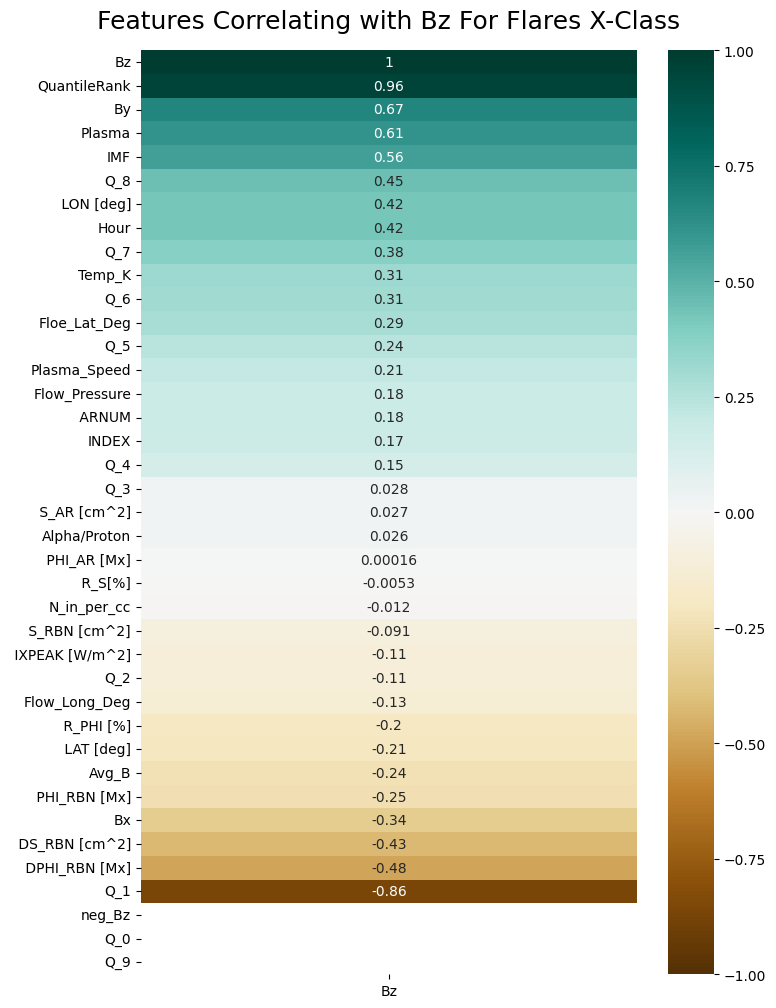

In [ ]:
df_cor = df_data[df_data['flare_class'] == 'X'].corr()[['Bz']].sort_values(by='Bz', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_cor[['Bz']].sort_values(by='Bz', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Bz For Flares X-Class', fontdict={'fontsize':18}, pad=16);

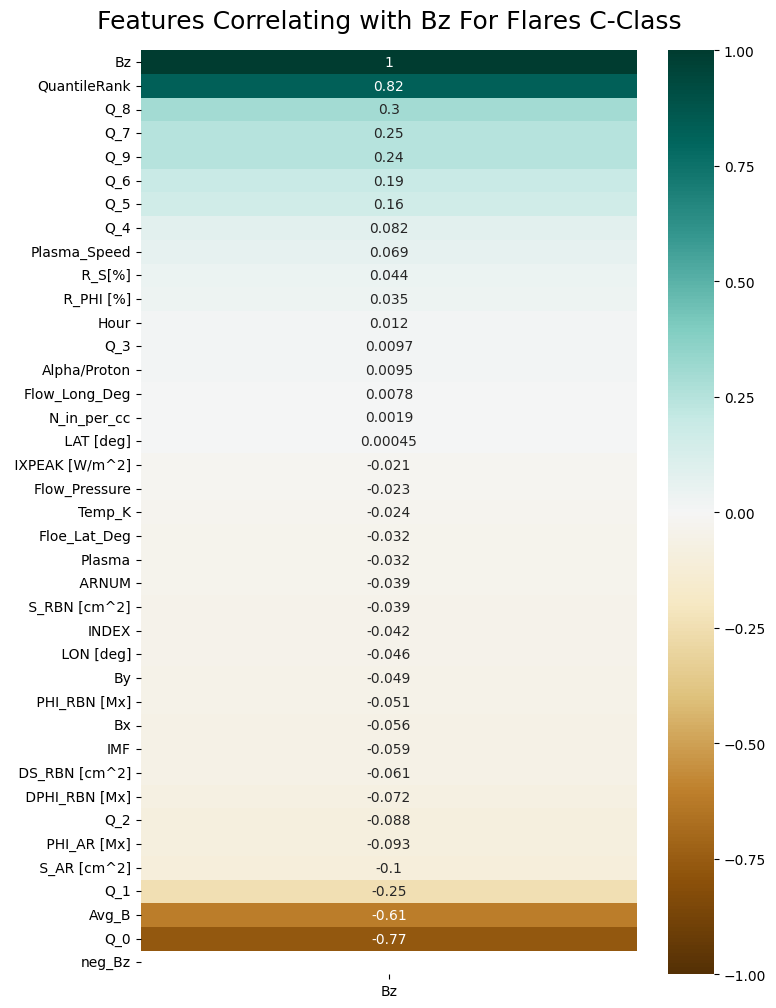

In [ ]:
df_cor = df_data[df_data['flare_class'] == 'C'].corr()[['Bz']].sort_values(by='Bz', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_cor[['Bz']].sort_values(by='Bz', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Bz For Flares C-Class', fontdict={'fontsize':18}, pad=16);

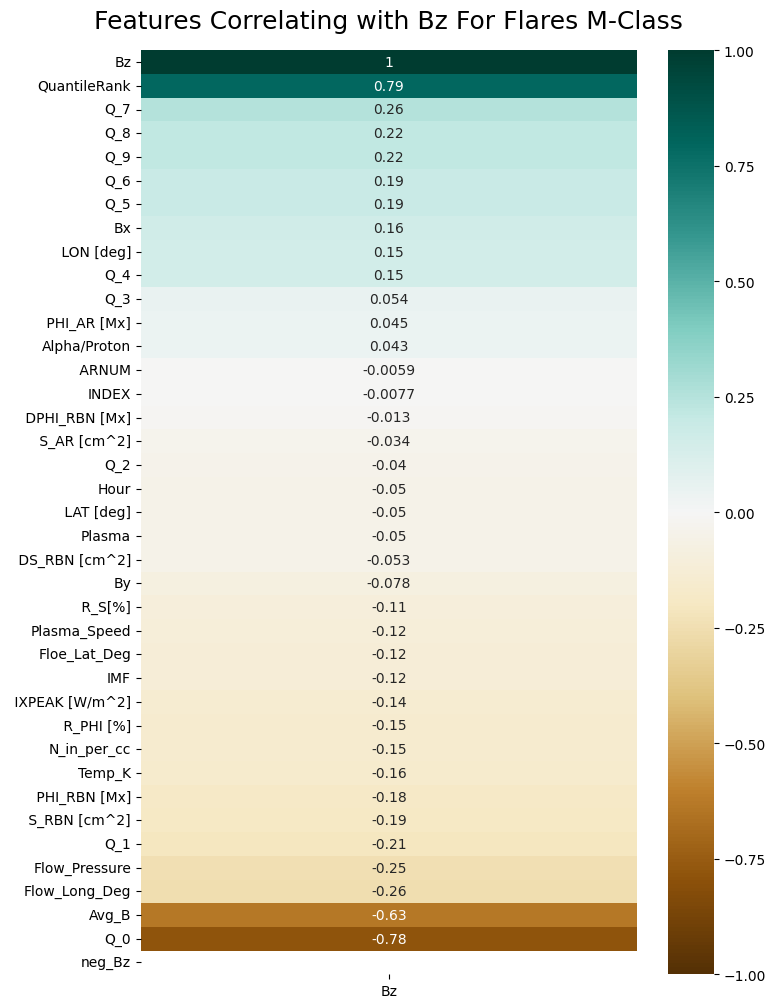

In [ ]:
df_cor = df_data[df_data['flare_class'] == 'M'].corr()[['Bz']].sort_values(by='Bz', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_cor[['Bz']].sort_values(by='Bz', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Bz For Flares M-Class', fontdict={'fontsize':18}, pad=16);

In [ ]:
# Vamos a selecionar los valores de BZ que estan en Q3 y Q0
df = df_data[(df_data['QuantileRank'] == 9) | (df_data['QuantileRank'] == 8) | (df_data['QuantileRank'] == 0)]
df['flare_class'].value_counts()

C    390
M     27
X      1
Name: flare_class, dtype: int64

Magnetic reconnection is the process through which magnetic energy is transformed into thermal and kinetic energy within laboratory, space, and astrophysical plasmas. Essentially, our focus should be on determining the rate at which magnetic reconnection converts magnetic energy into plasma thermal and kinetic energy. In our dataset, this rate is represented by correlations between solar flares and plasma speed, as well as the magnetic field component.

In [ ]:
df.corr()

,Bx,By,Bz,IMF,Plasma,Temp_K,N_in_per_cc,Plasma_Speed,Flow_Long_Deg,Floe_Lat_Deg,...,LON [deg],ARNUM,PHI_AR [Mx],PHI_RBN [Mx],DPHI_RBN [Mx],S_AR [cm^2],S_RBN [cm^2],DS_RBN [cm^2],R_PHI [%],R_S[%]
Bx,1.000000,-0.372517,-0.033631,-0.073860,-0.072065,-0.069184,0.109935,0.017853,0.027241,-0.196229,...,0.145331,-0.117850,-0.202467,-0.085705,-0.072708,-0.145991,-0.080056,-0.054318,-0.001088,-0.023649
By,-0.372517,1.000000,-0.099713,0.035684,0.000906,0.015236,-0.102414,-0.038590,-0.039296,0.107566,...,-0.127955,0.090209,0.139549,0.017902,0.010860,0.129837,0.030463,0.003854,-0.057048,-0.044758
Bz,-0.033631,-0.099713,1.000000,-0.136523,-0.086810,-0.103828,0.033897,0.056995,-0.070363,-0.076422,...,-0.038915,-0.055456,-0.101096,-0.127716,-0.115880,-0.138746,-0.120243,-0.119914,-0.046536,-0.034342
IMF,-0.073860,0.035684,-0.136523,1.000000,0.675002,0.015719,-0.704954,-0.025731,-0.085431,0.153299,...,0.102265,-0.123490,-0.045962,0.089871,0.076208,-0.041684,0.097852,0.085682,0.117948,0.129905
Plasma,-0.072065,0.000906,-0.086810,0.675002,1.000000,-0.064825,-0.408296,-0.061479,-0.093235,0.140066,...,0.002455,-0.210136,-0.093042,0.086582,0.076102,-0.023162,0.095330,0.085693,0.123805,0.104518
Temp_K,-0.069184,0.015236,-0.103828,0.015719,-0.064825,1.000000,0.043137,0.600195,0.440478,0.045630,...,-0.023842,-0.048486,-0.010106,0.058680,-0.023655,-0.043059,0.068845,0.009538,0.077029,0.114959
N_in_per_cc,0.109935,-0.102414,0.033897,-0.704954,-0.408296,0.043137,1.000000,0.017243,0.092467,-0.143813,...,-0.043679,0.068796,-0.022733,-0.037101,-0.040616,-0.040720,-0.045572,-0.039070,-0.018375,-0.024967
Plasma_Speed,0.017853,-0.038590,0.056995,-0.025731,-0.061479,0.600195,0.017243,1.000000,0.285814,0.092765,...,-0.010463,-0.006010,-0.040078,0.065552,-0.020218,-0.097964,0.097689,0.039532,0.071829,0.127288
Flow_Long_Deg,0.027241,-0.039296,-0.070363,-0.085431,-0.093235,0.440478,0.092467,0.285814,1.000000,0.129400,...,0.018526,-0.156556,0.017095,0.044174,0.026208,0.018635,0.029345,0.040669,0.021683,0.037439
Floe_Lat_Deg,-0.196229,0.107566,-0.076422,0.153299,0.140066,0.045630,-0.143813,0.092765,0.129400,1.000000,...,-0.000666,0.032684,0.157959,0.182056,0.144228,0.087144,0.183115,0.156726,0.079222,0.111149


In [ ]:
df.tail(3)

,Time,Mission_ID,Bx,By,Bz,IMF,Plasma,Temp_K,N_in_per_cc,Plasma_Speed,...,S_AR [cm^2],S_RBN [cm^2],DS_RBN [cm^2],R_PHI [%],R_S[%],dummy1,dummy2,dummy3,dummy4,flare_class
27075,2016-04-14T13:30:00.000Z,51,6.9,-1.0,-6.0,60.0,14.0,11229.0,5.3,459.0,...,7.646000e+19,2.117000e+18,5.865000e+17,3.3,2.8,20160414,1321,12529,C1.8,C
27080,2016-04-14T18:30:00.000Z,51,6.1,-2.2,-5.3,59.0,12.0,14631.0,6.1,428.0,...,9.266000e+19,1.253000e+18,4.997000e+17,1.7,1.4,20160414,1759,12529,C1.3,C
27105,2016-04-16T19:30:00.000Z,51,1.0,-2.7,-8.4,59.0,8.0,51167.0,12.4,412.0,...,8.499000e+19,2.730000e+18,6.568000e+17,3.2,3.2,20160416,1942,12529,C5.8,C


### Survival Analysis

In the following code, we implement survival analysis to our distribution of data 

In [ ]:
# definimos tau
df['Delta_T'] = df['Date'].diff()
df = df.dropna()
df['tau'] = df['Delta_T']/ np.timedelta64(1, 'h')
df = df[df['flare_class']!='X']

In [ ]:
df = df[df['tau'] > 0] 
E = df['neg_Bz']
T = df["tau"]

In the follwing plot we show the probability of ocurrence of a potential dangerous magnetic reconnection (high power) using the Kplan-Meier curve. This analisis is purely probabilistic. 

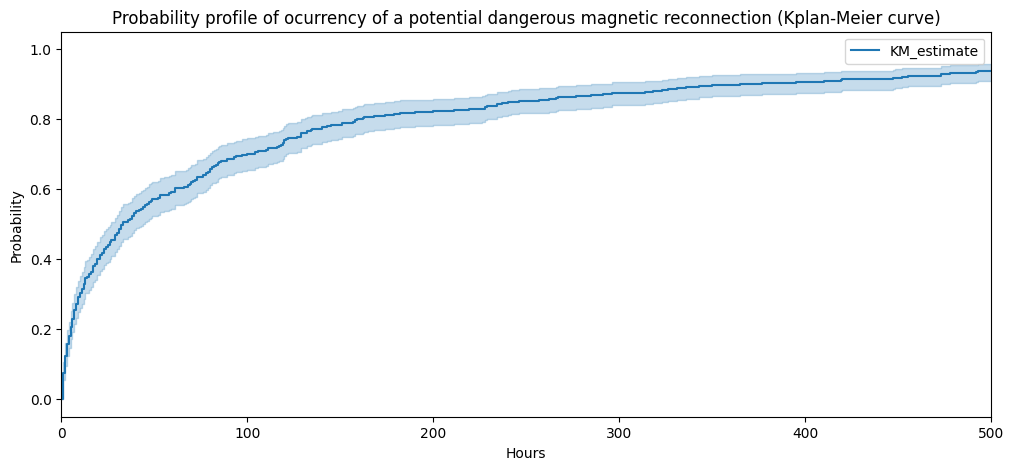

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
plt.figure(figsize = (12,5))
kmf.plot_cumulative_density()
plt.title("Probability profile of ocurrency of a potential dangerous magnetic reconnection (Kplan-Meier curve)")
plt.xlabel("Hours")
plt.ylabel("Probability")
plt.xlim(0,500)
plt.show()


The previous plot showed us that in 100 hours we will have a 70% of probability to have an important event. This estimation is made around the median of the high power magnetic reconnection events , which in our case is around 33.0 nT.       

In [ ]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('mediana', median_)
print(median_confidence_interval_)

mediana 33.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    27.0                    44.0


We can estimate that the next event will be between 27nT and 44nT, with 95% of probability.  We can also study the cases for solar flares of class M and class C.

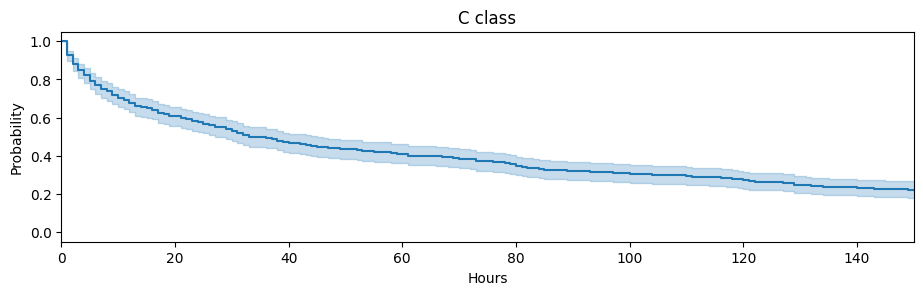

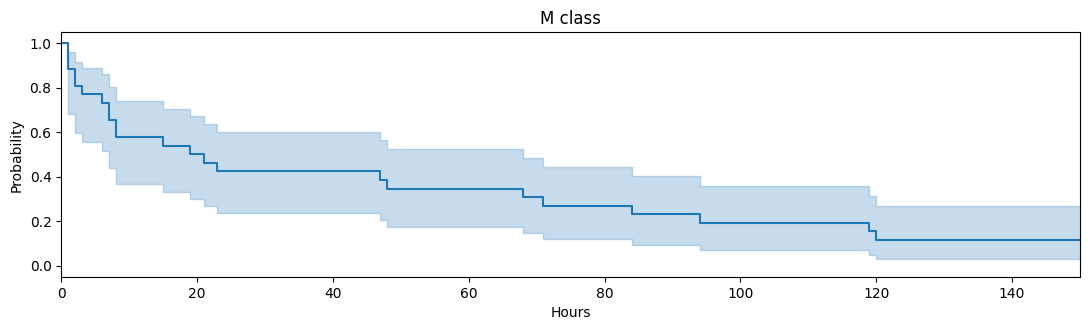

In [ ]:
flares_types = df.sort_values(by = ['flare_class'])["flare_class"].unique()

for i, flares_types in enumerate(flares_types):
    plt.figure(figsize = (11,6))
    ax = plt.subplot(2, 1, i + 1)
    ix = df['flare_class'] == flares_types
    kmf.fit(T[ix], E[ix], label = flares_types)
    kmf.plot_survival_function(ax = ax, legend = False)
    plt.title(flares_types + ' class')
    plt.xlabel("Hours")
    plt.ylabel("Probability")
    plt.xlim(0, 150)

plt.tight_layout()

The previous plots, shows the probability of no-ocurrence of the reconnection due to solar flares of class M and C. We can also study, the no-ocurrence by deciles.    

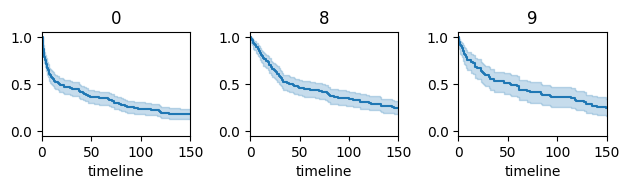

In [ ]:
q_types = df.sort_values(by = ['QuantileRank'])["QuantileRank"].unique()

for i, q_types in enumerate(q_types):
    ax = plt.subplot(3, 3, i + 1)
    ix = df_data['QuantileRank'] == q_types
    kmf.fit(T[ix], E[ix], label = q_types)
    kmf.plot_survival_function(ax = ax, legend = False)
    plt.title(q_types)
    plt.xlim(0, 150)

plt.tight_layout()

Now we fit the parameters to obtain the prediction.  

In [ ]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter


# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

cols = ['tau', 'neg_Bz','Bx', 'By', 'Bz', 'IMF', 'Plasma','N_in_per_cc', 'Plasma_Speed', 'Alpha/Proton', 'Flow_Pressure', 'Avg_B', 'Timestamp', 'Date', 'Hour',
       'Q_0','Q_8', 'Q_9', ' R_PHI [%]', ' R_S[%]']
df = df[cols]
df = df[df['tau'] < 150]
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = df["tau"],
            event_observed = df["neg_Bz"])
  # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 2820.632767900305
The AIC value for ExponentialFitter is 2845.723143563309
The AIC value for LogNormalFitter is 2836.3276716824184
The AIC value for LogLogisticFitter is 2859.4267679082936


The prediction takes the following values. 

In [ ]:
weibull_aft = WeibullAFTFitter()
df = df.tail(-5)
df_test = df.tail(5)
number_df = df.select_dtypes(include=['float','int64'])
weibull_aft.fit(number_df, duration_col='tau', event_col='neg_Bz')

#weibull_aft.print_summary()

X = df_test
weibull_aft.predict_cumulative_hazard(X, ancillary=X)
weibull_aft.predict_survival_function(X, ancillary=X)
weibull_aft.predict_median(X, ancillary=X)
weibull_aft.predict_percentile(X, p=0.9, ancillary=X)
pred = weibull_aft.predict_expectation(X, ancillary=X)
df_test['pred_exitosa'] = df_test['tau'] - pred
df_test['pred_exitosa'] = df_test.apply(lambda x: 1 if x['pred_exitosa'] <= 0 else 0, axis=1)
df_test['pred_exitosa']

26369    1
26376    1
26432    0
27080    1
27105    0
Name: pred_exitosa, dtype: int64

In [ ]:
pred

26369    15.333853
26376    25.226499
26432    49.427856
27080    41.636898
27105    23.362490
dtype: float64

In [ ]:
X

,tau,neg_Bz,Bx,By,Bz,IMF,Plasma,N_in_per_cc,Plasma_Speed,Alpha/Proton,...,Avg_B,Timestamp,Date,Hour,Q_0,Q_8,Q_9,R_PHI [%],R_S[%],pred_exitosa
26369,3.0,1,3.1,-9.5,-6.5,56.0,33.0,6.4,349.0,0.078,...,11.9,2016-02-12 00:30:00+00:00,2016-02-12 00:00:00,0,1,0,0,1.9,1.0,1
26376,17.0,1,1.1,-14.6,-0.1,61.0,37.0,15.0,347.0,0.029,...,14.7,2016-02-12 17:30:00+00:00,2016-02-12 17:00:00,17,0,0,1,5.4,3.0,1
26432,120.0,1,3.6,-4.5,-0.5,63.0,37.0,6.2,547.0,0.051,...,5.8,2016-02-17 17:30:00+00:00,2016-02-17 17:00:00,17,0,1,0,2.9,1.5,0
27080,5.0,1,6.1,-2.2,-5.3,59.0,12.0,6.1,428.0,0.030,...,8.4,2016-04-14 18:30:00+00:00,2016-04-14 18:00:00,18,1,0,0,1.7,1.4,1
27105,49.0,1,1.0,-2.7,-8.4,59.0,8.0,12.4,412.0,0.012,...,8.9,2016-04-16 19:30:00+00:00,2016-04-16 19:00:00,19,1,0,0,3.2,3.2,0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6eb17929-ce95-4d37-b9a8-d2d05de24b36' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>